In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [3]:
def get_precisions_recalls(actual, preds):
    # Définir les classes pour plus de clarté
    classes = ['Slight', 'Serious', 'Fatal']
    
    # Assurer que les entrées sont des arrays NumPy de chaînes de caractères pour les comparaisons
    actual = np.array(actual, dtype=str)
    preds = np.array(preds, dtype=str)
    
    # --- 1. CALCUL DES MÉTRIQUES ---
    
    # Calcul des Précisions
    precision_slight = np.sum((actual == classes[0]) & (preds == classes[0])) / np.sum(preds == classes[0])
    precision_serious = np.sum((actual == classes[1]) & (preds == classes[1])) / np.sum(preds == classes[1])
    precision_fatal = np.sum((actual == classes[2]) & (preds == classes[2])) / np.sum(preds == classes[2])

    precisions = [precision_slight, precision_serious, precision_fatal]

    # Calcul des Rappels (Recalls)
    # ATTENTION: Votre calcul de rappel initial utilisait des entiers (0, 1) alors que les précisions utilisaient des chaînes ('Slight', 'Serious').
    # Nous corrigeons cela pour utiliser les chaînes pour la cohérence.
    recall_slight = np.sum((actual == classes[0]) & (preds == classes[0])) / np.sum(actual == classes[0])
    recall_serious = np.sum((actual == classes[1]) & (preds == classes[1])) / np.sum(actual == classes[1])
    recall_fatal = np.sum((actual == classes[2]) & (preds == classes[2])) / np.sum(actual == classes[2])
    
    recalls = [recall_slight, recall_serious, recall_fatal]
    
    
    # --- 2. AFFICHAGE DES GRAPHIQUES ---
    
    plt.figure(figsize=(16, 6))
    x_pos = np.arange(len(classes)) # Positions pour les barres (0, 1, 2)
    
    # Sous-graphe pour la Précision
    plt.subplot(1, 2, 1)
    plt.bar(x_pos, precisions, color=['#1f77b4', '#ff7f0e', '#d62728']) # Couleurs distinctes
    
    plt.xticks(x_pos, classes, fontsize=16)
    plt.yticks(np.arange(0, 1.1, 0.1), fontsize=12)
    plt.ylabel('Précision', fontsize=18)
    
    # Construction du titre avec les trois précisions
    title_precision = (
        f'Précision {classes[0]}: {round(precisions[0], 2)}\n'
        f'Précision {classes[1]}: {round(precisions[1], 2)}\n'
        f'Précision {classes[2]}: {round(precisions[2], 2)}'
    )
    plt.title(title_precision, fontsize=14)
    
    # Sous-graphe pour le Rappel (Recall)
    plt.subplot(1, 2, 2)
    plt.bar(x_pos, recalls, color=['#1f77b4', '#ff7f0e', '#d62728'])
    
    plt.xticks(x_pos, classes, fontsize=16)
    plt.yticks(np.arange(0, 1.1, 0.1), fontsize=12)
    plt.ylabel('Rappel', fontsize=18)
    
    # Construction du titre avec les trois rappels
    title_recall = (
        f'Rappel {classes[0]}: {round(recalls[0], 2)}\n'
        f'Rappel {classes[1]}: {round(recalls[1], 2)}\n'
        f'Rappel {classes[2]}: {round(recalls[2], 2)}'
    )
    plt.title(title_recall, fontsize=14)
    
    plt.tight_layout()
    plt.show()

# Generate/Read Data

In [4]:
mode = 'read'

In [ ]:
def read_data():
    outcome = "Accident_Severity" 
    df = pd.read_csv('Road Accident Data.csv')
    df =df.drop(columns=['Accident Date', 'Carriageway_Hazards','Accident_Index','Latitude','Local_Authority_(District)','Longitude'],errors='ignore')
    
    #separate features and target
    X = df.drop(columns=outcome)
    y = df[outcome].values
    
    X_encoded = pd.get_dummies(X, columns=X.select_dtypes(include=['object']).columns)

    X_array = X_encoded.values.astype(float)

    X_train, X_test, y_train, y_test = train_test_split(
        X_array,
        y,
        test_size=0.3,
        random_state =42,
        stratify=y # enable to keep 5% of fatal in training and testing
    )

    return X_train, y_train, X_test, y_test

In [6]:
n_train = 10000
n_test = 10000
k = 10
cutoff = 0.5
weights = np.random.random((k,1))

In [ ]:
X_train, labels_train, X_test, labels_test = read_data()

# Train Decision Tree

In [34]:
clf = DecisionTreeClassifier()
clf.fit(X_train, labels_train)
preds = clf.predict(X_test)

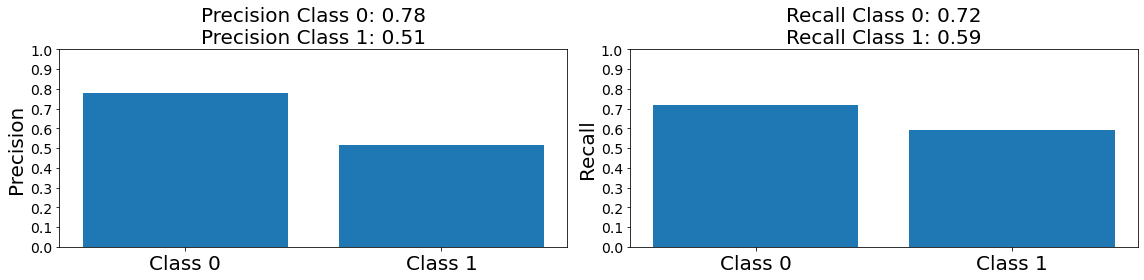

In [35]:
get_precisions_recalls(labels_test, preds)

# Solution 1: Upweight the Minority Class

In [36]:
MAJORITY_CLASS = 'Slight'
MINORITY_CLASSES = ['Serious', 'Fatal']

# 1. Calculer le nombre d'échantillons pour chaque classe
count_slight = np.sum(labels_train == MAJORITY_CLASS)
count_serious = np.sum(labels_train == MINORITY_CLASSES[0])
count_fatal = np.sum(labels_train == MINORITY_CLASSES[1])

# 2. Initialiser le dictionnaire de poids
class_weights = {}

# 3. Calculer les poids
# Le poids de la classe majoritaire est généralement fixé à 1.
class_weights[MAJORITY_CLASS] = 1.0

# Les poids des classes minoritaires sont calculés par la formule :
# Poids = (Count de la classe Majoritaire) / (Count de la classe Minoritaire)

# Poids pour 'Serious'
if count_serious > 0:
    class_weights[MINORITY_CLASSES[0]] = count_slight / count_serious
else:
    # Si la classe est absente, on peut lui donner un poids très élevé ou 0 si on veut l'ignorer.
    # Dans ce contexte, il est plus sûr d'utiliser une autre méthode (ex: 'balanced') ou de lever une alerte.
    class_weights[MINORITY_CLASSES[0]] = 0 

# Poids pour 'Fatal'
if count_fatal > 0:
    class_weights[MINORITY_CLASSES[1]] = count_slight / count_fatal
else:
    class_weights[MINORITY_CLASSES[1]] = 0

print("Poids calculés :", class_weights)

Poids calculés : {'Slight': 1.0, 'Serious': 6.462444771723122, 'Fatal': 66.60498735092158}


In [41]:
clf = DecisionTreeClassifier(class_weight=class_weights) #utilise le dictionnaire class_weights
clf.fit(X_train, labels_train)
preds = clf.predict(X_test)

clf_visual = DecisionTreeClassifier(
    max_depth=3,  # Limitez la profondeur à 3 niveaux
    random_state=42
).fit(X_train, labels_train)

['Year', 'Number_of_Casualties', 'Number_of_Vehicles', 'Speed_limit', 'Month_Apr', 'Month_Aug', 'Month_Dec', 'Month_Feb', 'Month_Jan', 'Month_Jul', 'Month_Jun', 'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep', 'Day_of_Week_Friday', 'Day_of_Week_Monday', 'Day_of_Week_Saturday', 'Day_of_Week_Sunday', 'Day_of_Week_Thursday', 'Day_of_Week_Tuesday', 'Day_of_Week_Wednesday', 'Junction_Control_Authorised person', 'Junction_Control_Auto traffic signal', 'Junction_Control_Data missing or out of range', 'Junction_Control_Give way or uncontrolled', 'Junction_Control_Not at junction or within 20 metres', 'Junction_Control_Stop sign', 'Junction_Detail_Crossroads', 'Junction_Detail_Mini-roundabout', 'Junction_Detail_More than 4 arms (not roundabout)', 'Junction_Detail_Not at junction or within 20 metres', 'Junction_Detail_Other junction', 'Junction_Detail_Private drive or entrance', 'Junction_Detail_Roundabout', 'Junction_Detail_Slip road', 'Junction_Detail_T or staggered junction', 

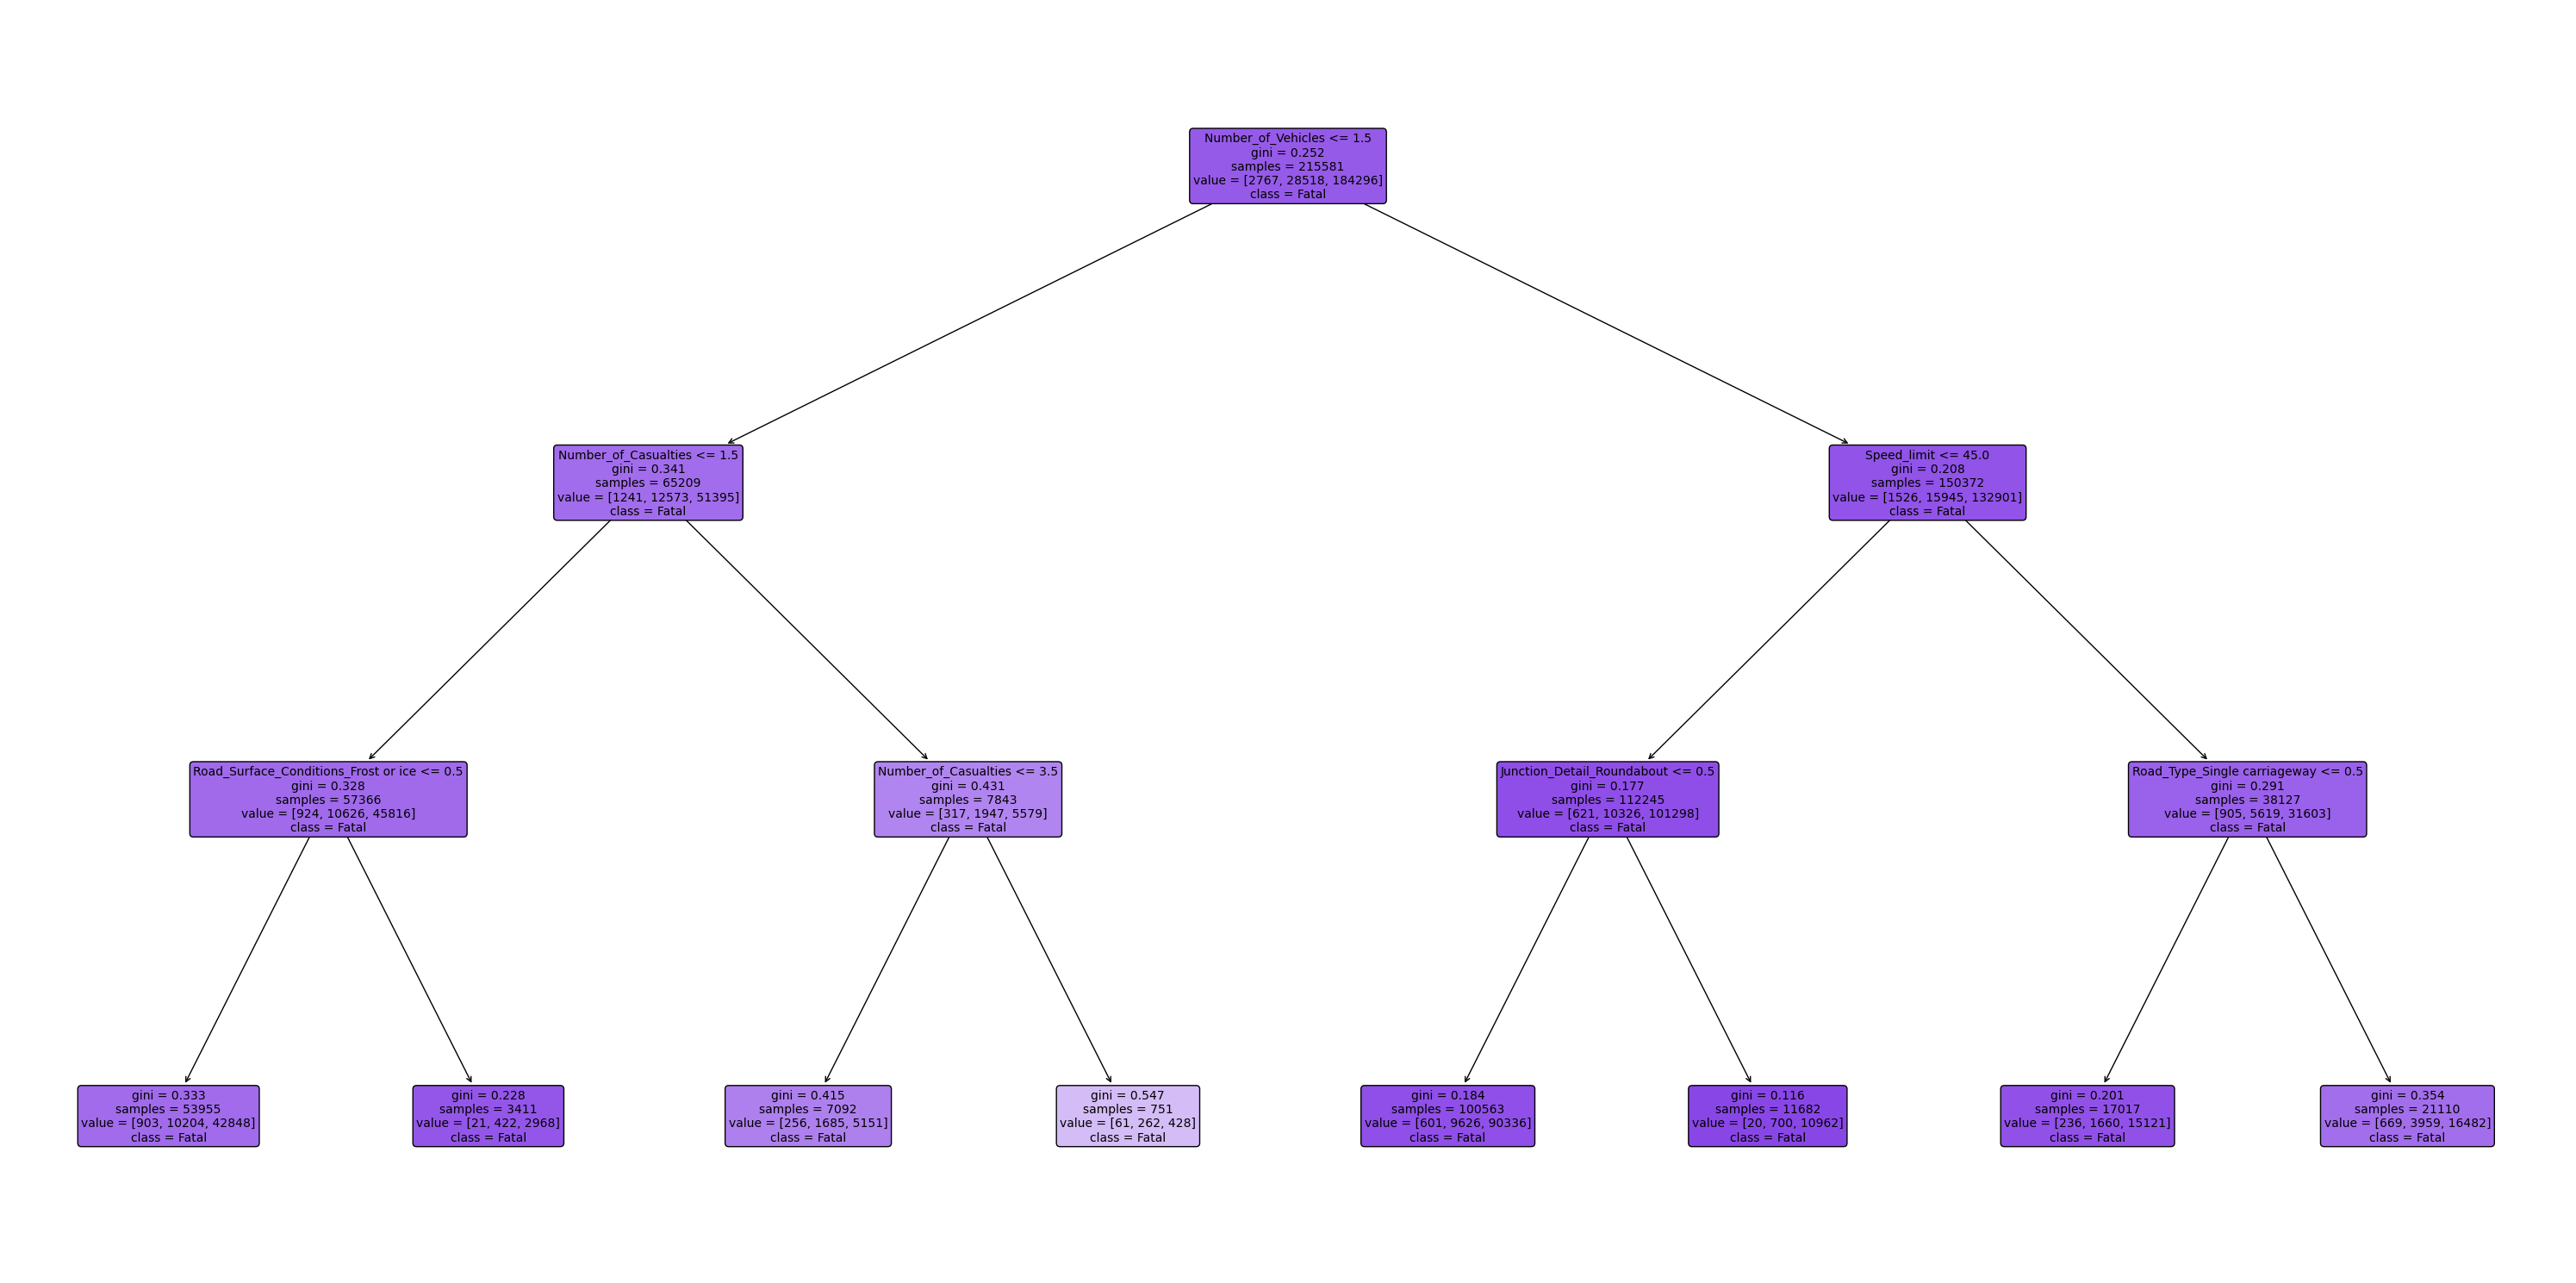

In [48]:

# 1. Chargement et nettoyage des données (comme dans read_data)
df = pd.read_csv('Road Accident Data.csv')

# Séparer l'Outcome (la variable à prédire) pour l'encodage
# Accident_Severity contient les étiquettes 'Slight', 'Serious', 'Fatal' (y)
y_labels = df['Accident_Severity'] 

# X_raw correspond à X dans votre fonction read_data()
X_raw = df.drop(
    columns=['Accident Date','Accident_Severity', 'Carriageway_Hazards','Accident_Index','Latitude','Local_Authority_(District)','Longitude'],
    errors='ignore'
)

# 2. ENCODAGE des données catégorielles (création de X_encoded)
# C'est l'étape qui était manquante/non exécutée dans votre bloc !
X_encoded = pd.get_dummies(X_raw)

# 3. Récupérer les noms de colonnes CORRECTEMENT
feature_names = list(X_encoded.columns)

print(feature_names)

plt.figure(figsize=(30, 15))
plot_tree(
    clf_visual,
    feature_names=feature_names, # Pour nommer les conditions de split
    class_names=['Slight', 'Serious', 'Fatal'],        # Pour nommer les feuilles finales
    filled=True,                                       # Pour colorer les nœuds par classe
    rounded=True,
    fontsize=10
)
plt.tight_layout()
plt.show()

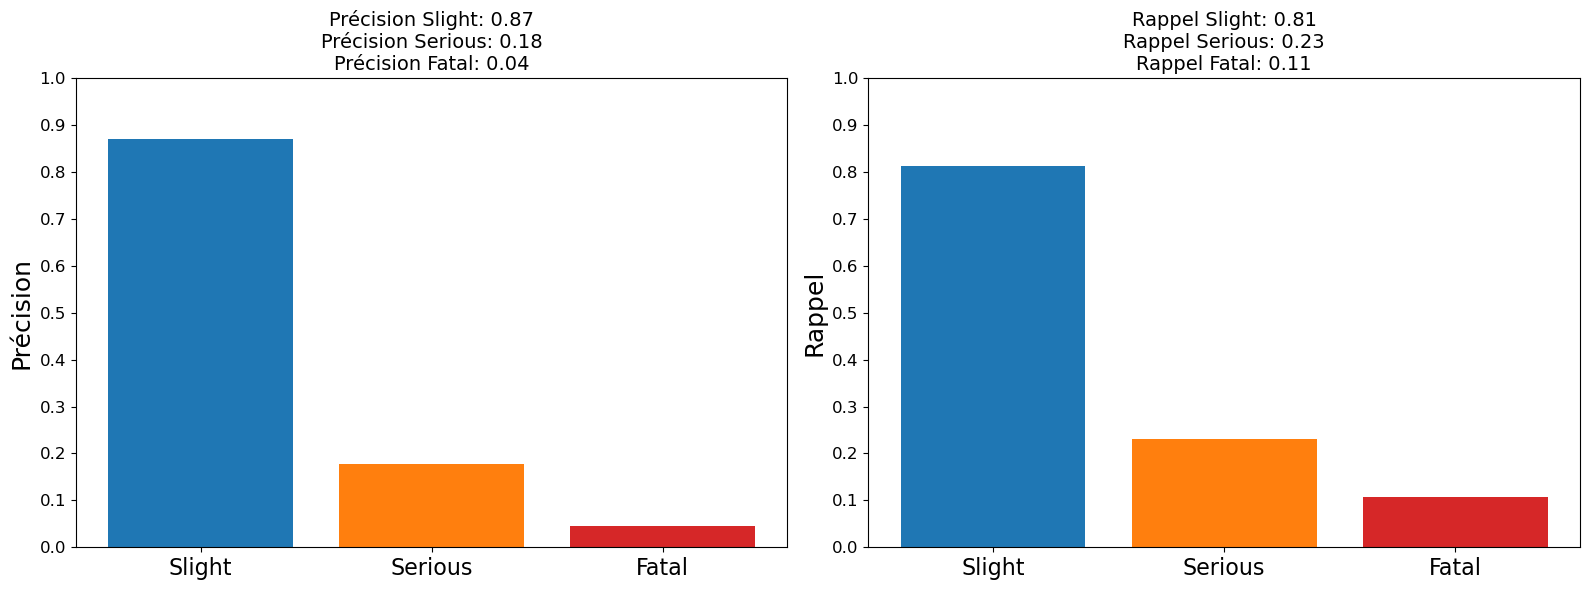

In [13]:
get_precisions_recalls(labels_test, preds)

# Solution 2: Oversample Minority Class

In [ ]:
labels_series = pd.Series(labels_train)

# Appliquer le dictionnaire class_weights pour obtenir le poids de chaque échantillon
weights = labels_series.map(class_weights).values

# 2. Normalisation des poids en probabilités
# La somme des probabilités doit être égale à 1 pour np.random.choice
weights = weights / np.sum(weights)


# 3. Échantillonnage des nouveaux indices
# np.arange(labels_train.shape[0]) donne tous les indices de 0 à N-1
indices = np.arange(labels_train.shape[0]) 

# Échantillonner (avec remplacement) le même nombre d'échantillons, 
# en utilisant 'weights' comme probabilités de sélection (p=weights).
sampled_indices = np.random.choice(
    indices, 
    size=labels_train.shape[0], # Échantillonner le même nombre total d'échantillons
    p=weights, 
    replace=True # Important : permet de sélectionner plusieurs fois les échantillons minoritaires
)

In [ ]:
#consruct oversampled datasets
X_train_oversampled = X_train[sampled_indices]
labels_train_oversampled = labels_train[sampled_indices]

In [ ]:
# 1. Calculer le nombre total d'échantillons dans le nouvel ensemble
total_sampled = len(labels_train_oversampled)

# 2. Calculer le nombre d'occurrences pour chaque classe minoritaire
count_serious = np.sum(labels_train_oversampled == 'Serious')
count_fatal = np.sum(labels_train_oversampled == 'Fatal')

# 3. Calculer la fraction de chaque classe minoritaire
fraction_serious = count_serious / total_sampled
fraction_fatal = count_fatal / total_sampled

# 4. Afficher les résultats (en pourcentage)

print("--- Distribution des classes dans les données Ré-échantillonnées ---")

print(f"Échantillons totaux : {total_sampled}")

print(
    f"Fraction de la classe 'Serious' : "
    f"{round(100 * fraction_serious, 3)}% "
    f"({count_serious} échantillons)"
)

print(
    f"Fraction de la classe 'Fatal' : "
    f"{round(100 * fraction_fatal, 3)}% "
    f"({count_fatal} échantillons)"
)

In [43]:
clf = DecisionTreeClassifier()
clf.fit(X_train_oversampled, labels_train_oversampled)
preds = clf.predict(X_test)

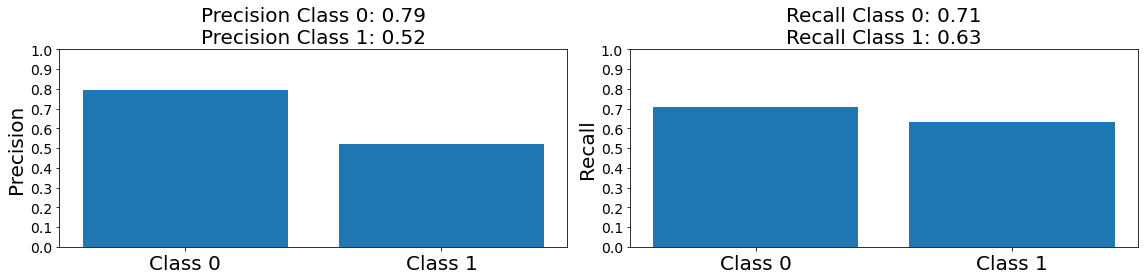

In [44]:
get_precisions_recalls(labels_test, preds)

# Solution 2a: SMOTE (Synthetic Minority Oversampling TEchnique)

In [14]:
# Définition des classes
CLASSES = ['Slight', 'Serious', 'Fatal']

# 1. Extraire les poids dans le bon ordre
weights_raw = [class_weights[c] for c in CLASSES]

# 2. Convertir les poids en probabilités de sélection
# Si on veut que la probabilité d'échantillonner chaque classe soit proportionnelle à son poids:
sampling_probabilities = np.array(weights_raw)
sampling_probabilities = sampling_probabilities / np.sum(sampling_probabilities)

# Exemple de sampling_probabilities: [0.02, 0.08, 0.90] 
# (où 'Fatal' a une très forte chance d'être sélectionné pour la boucle)

print("Probabilités de sélection pour la boucle (Slight, Serious, Fatal) :", sampling_probabilities)


# --- 3. Définir les indices (si ce n'est pas déjà fait) ---
indices_slight = np.where(labels_train == 'Slight')[0]
indices_serious = np.where(labels_train == 'Serious')[0]
indices_fatal = np.where(labels_train == 'Fatal')[0]

# Dictionnaire pour mapper la classe aux indices
indices_map = {
    'Slight': indices_slight,
    'Serious': indices_serious,
    'Fatal': indices_fatal
}

Probabilités de sélection pour la boucle (Slight, Serious, Fatal) : [0.01350121 0.08725083 0.89924796]


In [15]:
X_train_oversampled_smote = []
labels_train_oversampled_smote = []
total_new_samples = X_train.shape[0] * 2 # Souvent, l'oversampling DOUBLE ou TRIPLE la taille

for _ in range(total_new_samples):
    # Choisir la classe à générer/échantillonner en utilisant les probabilités pondérées
    selected_class = np.random.choice(CLASSES, p=sampling_probabilities)
    
    # --- 1. Échantillonnage de la classe Majoritaire ('Slight') ---
    if selected_class == 'Slight':
        # Simplement échantillonner sans synthétisation
        indices_samp = indices_map['Slight']
        if len(indices_samp) > 0:
            sample_index = np.random.choice(indices_samp)
            X_train_oversampled_smote.append(X_train[sample_index])
            labels_train_oversampled_smote.append('Slight')
        
    # --- 2. Synthétisation des classes Minoritaires ('Serious' et 'Fatal') ---
    else:
        indices_samp = indices_map[selected_class]
        label_samp = selected_class
        
        # Vérification minimale pour s'assurer que la classe contient au moins 2 échantillons
        if len(indices_samp) >= 2:
            
            # Obtenir deux échantillons aléatoires de cette classe minoritaire
            # (On utilise replace=True si la classe est très petite)
            idx_1, idx_2 = np.random.choice(indices_samp, size=2, replace=True) 
            
            minority_samp_1 = X_train[idx_1]
            minority_samp_2 = X_train[idx_2]
            
            # Obtenir une proportion aléatoire
            prop = np.random.random()
            
            # Générer l'échantillon synthétique par interpolation linéaire
            synthetic_minority_samp = prop * minority_samp_1 + (1 - prop) * minority_samp_2
            
            # ⚠️ Si X_train vient de pd.get_dummies, vous DEVEZ ARRONDISSEMENT
            synthetic_minority_samp = np.round(synthetic_minority_samp) 
            
            X_train_oversampled_smote.append(synthetic_minority_samp)
            labels_train_oversampled_smote.append(label_samp)
        
        # Si la classe est sélectionnée mais qu'elle est trop petite (0 ou 1 échantillon)
        elif len(indices_samp) > 0:
            # Revertir à un simple ré-échantillonnage si on ne peut pas synthétiser
            sample_index = np.random.choice(indices_samp)
            X_train_oversampled_smote.append(X_train[sample_index])
            labels_train_oversampled_smote.append(label_samp)

# Conversion finale en arrays
X_train_oversampled_smote = np.array(X_train_oversampled_smote)
labels_train_oversampled_smote = np.array(labels_train_oversampled_smote)

In [20]:

# Définition des classes minoritaires
MINORITY_CLASSES = ['Serious', 'Fatal']

print("--- Évaluation de l'Unicité des Vecteurs après Synthétisation (SMOTE) ---")

# --------------------------------------------------------------------------
# Préparation : Calculer le nombre d'échantillons originaux uniques (BASE)
# --------------------------------------------------------------------------

unique_original_base = {}
# Tentative de calcul de la taille de l'ensemble original (on utilise .shape[0])
original_size = {} 

try:
    # On utilise X_train et labels_train (les données AVANT SMOTE)
    X_original_serious = X_train[labels_train == 'Serious']
    X_original_fatal = X_train[labels_train == 'Fatal']
    
    unique_original_base['Serious'] = np.unique(X_original_serious, axis=0).shape[0]
    unique_original_base['Fatal'] = np.unique(X_original_fatal, axis=0).shape[0]
    
    # On enregistre la taille ORIGINALE de la classe (qui doit correspondre à unique_original_base si aucune duplication n'existait)
    original_size['Serious'] = X_original_serious.shape[0]
    original_size['Fatal'] = X_original_fatal.shape[0]

except NameError:
    print("\nAVERTISSEMENT : Les variables X_train/labels_train ne sont pas disponibles. Impossible de calculer la base originale.")
    unique_original_base = {'Serious': 0, 'Fatal': 0}
    original_size = {'Serious': 0, 'Fatal': 0}

# --------------------------------------------------------------------------
# Calcul de l'Unicité sur les données SMOTE
# --------------------------------------------------------------------------

# Boucle sur les deux classes minoritaires
for target_class in MINORITY_CLASSES:
    print(f"\nClasse Cible : {target_class}")
    
    # 1. Sélection des vecteurs de caractéristiques pour la classe cible après SMOTE
    subset_smote = X_train_oversampled_smote[labels_train_oversampled_smote == target_class]
    
    # 2. Calcul du nombre de vecteurs de caractéristiques uniques
    unique_smote = np.unique(subset_smote, axis=0).shape[0]
    total_smote_samples = subset_smote.shape[0]
    
    # ---------------------------------------------------------------------
    # NOUVEAU CALCUL ET AFFICHAGE DES DONNÉES AJOUTÉES
    # ---------------------------------------------------------------------
    base_size = original_size.get(target_class, 0)
    
    if base_size > 0:
        # Données ajoutées = Total Échantillons SMOTE - Taille de l'ensemble d'origine
        added_samples = total_smote_samples - base_size
        
        # Affichage des résultats
        print(f'   Total Échantillons ({target_class} SMOTE)  : {total_smote_samples}')
        print(f'   Taille Ensemble Original   : {base_size}')
        print(f'   --- DONNÉES AJOUTÉES (SMOTE) : {added_samples}') # <--- NOUVELLE LIGNE
    else:
        print(f'   Total Échantillons ({target_class} SMOTE)  : {total_smote_samples}')
        
    # ---------------------------------------------------------------------
    # Reste de l'évaluation
    
    base_uniques = unique_original_base.get(target_class, 0)
    
    if base_uniques > 0:
        increase = unique_smote - base_uniques
        increase_percent = (increase / base_uniques) * 100
        
        print(f"   Num Vecteurs Uniques ({target_class} SMOTE): {unique_smote}")
        print(f"   Vecteurs Uniques Originaux : {base_uniques}")
        print(f"   Augmentation des Uniques   : {increase} ({increase_percent:.1f}%)")
        
        if unique_smote > base_uniques:
            print(f"   >>> RÉSULTAT : Succès ! De nouveaux vecteurs uniques pour '{target_class}' ont été générés.")
        else:
            print(f"   <<< ATTENTION : Le nombre de vecteurs uniques pour '{target_class}' n'a pas augmenté. L'arrondi est probablement en cause.")
    
    if total_smote_samples > 0:
        ratio_unique_smote = unique_smote / total_smote_samples
        print(f"   Ratio Uniques/Total        : {ratio_unique_smote:.4f}")

--- Évaluation de l'Unicité des Vecteurs après Synthétisation (SMOTE) ---

Classe Cible : Serious
   Total Échantillons (Serious SMOTE)  : 37476
   Taille Ensemble Original   : 28518
   --- DONNÉES AJOUTÉES (SMOTE) : 8958
   Num Vecteurs Uniques (Serious SMOTE): 32854
   Vecteurs Uniques Originaux : 28516
   Augmentation des Uniques   : 4338 (15.2%)
   >>> RÉSULTAT : Succès ! De nouveaux vecteurs uniques pour 'Serious' ont été générés.
   Ratio Uniques/Total        : 0.8767

Classe Cible : Fatal
   Total Échantillons (Fatal SMOTE)  : 387841
   Taille Ensemble Original   : 2767
   --- DONNÉES AJOUTÉES (SMOTE) : 385074
   Num Vecteurs Uniques (Fatal SMOTE): 96581
   Vecteurs Uniques Originaux : 2767
   Augmentation des Uniques   : 93814 (3390.5%)
   >>> RÉSULTAT : Succès ! De nouveaux vecteurs uniques pour 'Fatal' ont été générés.
   Ratio Uniques/Total        : 0.2490


In [17]:
clf = DecisionTreeClassifier()
clf.fit(X_train_oversampled_smote, labels_train_oversampled_smote)
preds = clf.predict(X_test)

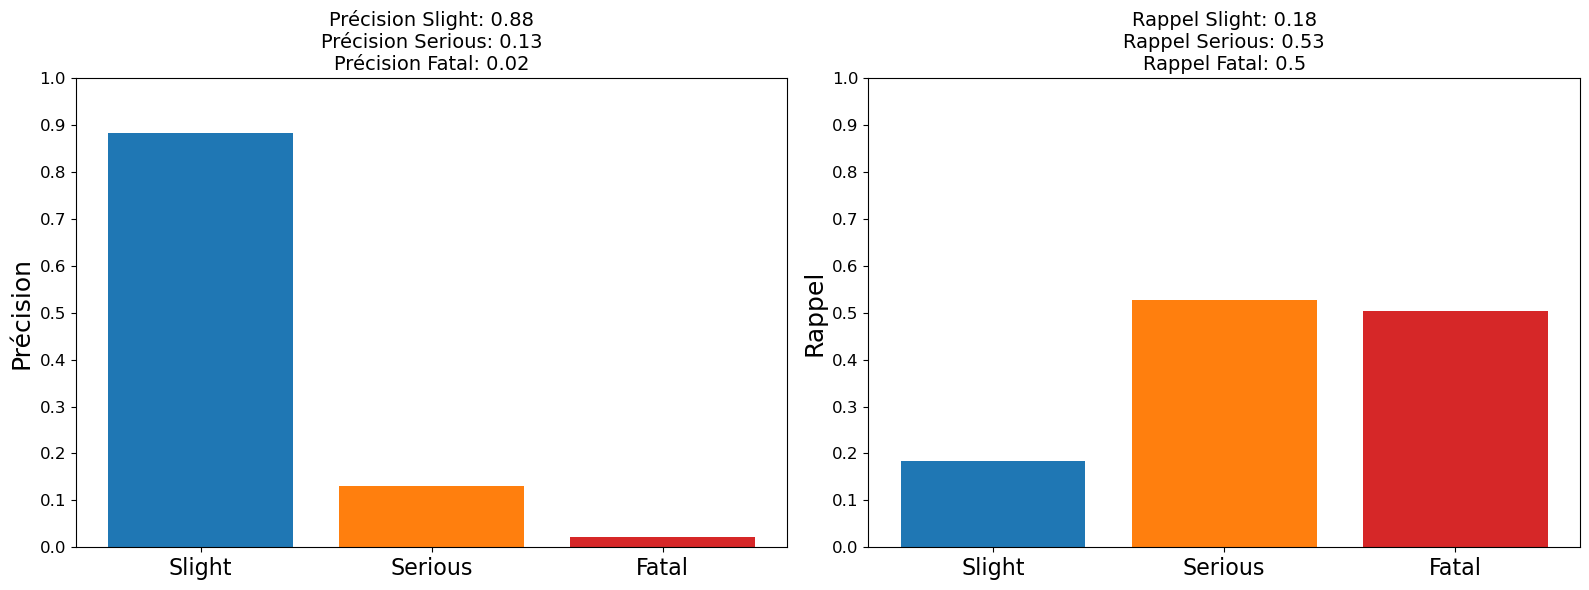

In [18]:
get_precisions_recalls(labels_test, preds)

In [21]:
def calculate_f1_from_pr(precision, recall):
    """
    Calcule le Score F1 à partir d'une Précision et d'un Rappel donnés.

    Args:
        precision (float): La valeur de la Précision (entre 0.0 et 1.0).
        recall (float): La valeur du Rappel (entre 0.0 et 1.0).

    Returns:
        float: Le Score F1 (entre 0.0 et 1.0).
    """

    # Vérification pour éviter une division par zéro si les deux sont 0
    if (precision + recall) > 0:
        # Formule du Score F1 (Moyenne Harmonique)
        f1_score = 2 * (precision * recall) / (precision + recall)
    else:
        f1_score = 0.0
        
    return f1_score

In [22]:
print(calculate_f1_from_pr(0.86,0.9))
print(calculate_f1_from_pr(0.17,0.13))
print(calculate_f1_from_pr(0.03,0.02))

0.8795454545454545
0.14733333333333332
0.023999999999999997


In [24]:
print(calculate_f1_from_pr(0.87,0.81))
print(calculate_f1_from_pr(0.18,0.23))
print(calculate_f1_from_pr(0.05,0.11))

0.8389285714285714
0.2019512195121951
0.06875


In [25]:
print(calculate_f1_from_pr(0.88,0.18))
print(calculate_f1_from_pr(0.13,0.53))
print(calculate_f1_from_pr(0.02,0.5))

0.29886792452830185
0.2087878787878788
0.038461538461538464
